# CPA - First Keybyte

The code in this notebook will calculate the CPA for the firsts keybytes of Speck

## 1. Loading the Data

In [84]:
import numpy as np
trace_array = np.load("sample_traces/2000_encryption_traces.npy")
textin_array = np.load("sample_traces/2000_plaintext_traces.npy")

trace_array = np.array(trace_array)
textin_array = np.array(textin_array)

## Example Plot

<IPython.core.display.Javascript object>


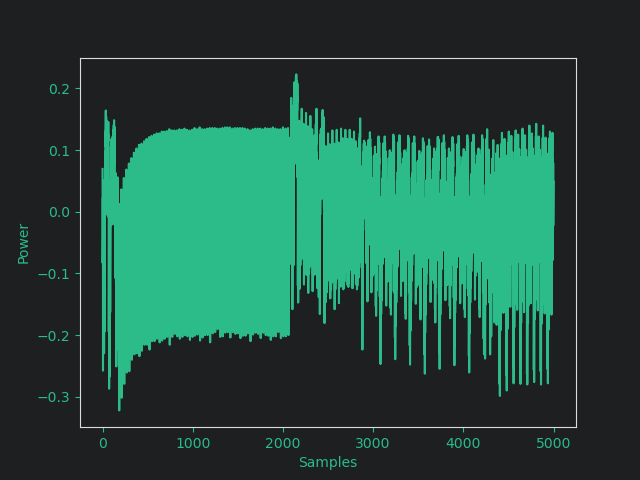

In [85]:
%matplotlib notebook
import matplotlib.pylab as plt

# Setting the Plot Color:
plt.figure(facecolor='#1d1f21')
ax = plt.axes()
ax.set_facecolor("#1d1f21")
plt.xlabel("Samples")
plt.ylabel("Power")
ax.tick_params(axis='x', colors='#2bbc8a')
ax.tick_params(axis='y', colors='#2bbc8a')
ax.yaxis.label.set_color('#2bbc8a')
ax.xaxis.label.set_color('#2bbc8a')

ax.spines['bottom'].set_color('#dddddd')
ax.spines['top'].set_color('#dddddd') 
ax.spines['right'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')


plt.plot(trace_array[1], '#2bbc8a')
plt.show()

## 2. Defining the Speck Model and Helper Functions

### Helpers

The following method (`popcount`) calculates the Hamming Weight of an integer

In [86]:
#Hamming Weight
def popcount(x):
    x -= (x >> 1) & 0x5555555555555555
    x = (x & 0x3333333333333333) + ((x >> 2) & 0x3333333333333333)
    x = (x + (x >> 4)) & 0x0f0f0f0f0f0f0f0f
    return ((x * 0x0101010101010101) & 0xffffffffffffffff ) >> 56

### Further functions for the Pearson Correlation Coefficient (PCC)

In [87]:
def mean(X):
    return np.sum(X, axis=0)/len(X)

def std_dev(X, X_bar):
    return np.sqrt(np.sum((X-X_bar)**2, axis=0))

def cov(X, X_bar, Y, Y_bar):
    return np.sum((X-X_bar)*(Y-Y_bar), axis=0)

def to16(byte1, byte2):
    return int((byte1 << 8) + byte2)

### Speck Model

In [88]:
import math

NUM_ROUNDS = 22
BLOCK_SIZE = 32
KEY_SIZE = 64
WORD_SIZE = 16


# SHIFTs for SPECK
ALPHA = 7
BETA = 2

mod_mask = (2 ** WORD_SIZE) -1
mod_mask_sub = (2 ** WORD_SIZE)


# The implementation of the round function
def ER16(x, y, k):

    rs_x = ((x << (16 - ALPHA)) + (x >> ALPHA)) & mod_mask
    add_sxy = (rs_x + y) & mod_mask
    new_x = k ^ add_sxy
    ls_y = ((y >> (16 - BETA)) + (y << BETA)) & mod_mask
    new_y = new_x ^ ls_y

    return new_x, new_y


In [89]:
# Software Model for the correlations of the first keybytes
def simple_speck(plaintext, key, arg=None):

    Ct_0 = (int(plaintext[1]) << 8) + int(plaintext[0])
    Ct_1 = (int(plaintext[3]) << 8) + int(plaintext[2])
                                                
    
    Ct_1, Ct_0 = ER16(Ct_1, Ct_0, key)   # fixed 16 bit key of 0x55
    return popcount((Ct_1 << 8) + Ct_0)

### Normalize Data

Because of some weird `np.save()` thingy, it seems that leading null-bytes in the textin array are getting removed...

In [90]:
textin_cleaned = []
traces_cleaned = []

for (i ,pt) in enumerate(textin_array):
    if len(pt) != 4:
       continue
    textin_cleaned.append(pt)
    traces_cleaned.append(trace_array[i])

## 3. Calculating the Correlations

In [91]:
def calculate_correlations(traces, plaintexts, model_callback, leftmost=True, other_keybyte=0x00, argument=None):
    
    maxcpa = [0] * 256   # Correlations
    
    # Calculate mean and standard derivation
    t_bar = mean(traces) 
    o_t = std_dev(traces, t_bar)
    
    
    for key in range(0, 256):
        
        # Run the model
        if leftmost:
            hws = np.array([[model_callback(pt, (key << 8) + other_keybyte, argument) for pt in plaintexts]]).transpose()
        elif not leftmost:
            hws = np.array([[model_callback(pt, (other_keybyte << 8) + key, argument) for pt in plaintexts]]).transpose()
        else:
            raise Exception("[-] Invalid Key Position")
            
        # Calculating the correlation using the pearson correlation coefficient
        hws_bar = mean(hws)
        o_hws = std_dev(hws, hws_bar)
        correlation = cov(traces, t_bar, hws, hws_bar)
        cpaoutput = correlation/(o_t*o_hws)
        maxcpa[key] = max(abs(cpaoutput))
    
    # Return the two best guesses
    best_guess = int(np.argmax(maxcpa))
    second_guess = int(np.argsort(maxcpa, axis=0)[-2])
    
    return best_guess, maxcpa

#### This function can be used to calculate the first two keybytes for Speck:

In [92]:
keybyte, correlation = calculate_correlations(traces_cleaned, textin_cleaned, simple_speck, True, 0x00)

In [93]:
print(f"The correct first keybyte is: {hex(keybyte)} with a correlation of {correlation[keybyte]}")

The correct first keybyte is: 0x22 with a correlation of 0.38797752579567957


In [94]:
second_keybyte, _ = calculate_correlations(traces_cleaned, textin_cleaned, simple_speck, False, keybyte)

In [95]:
print(f"The correct second keybyte is: {hex(second_keybyte)}")

The correct second keybyte is: 0x11


## Plotting the Correlation

<IPython.core.display.Javascript object>


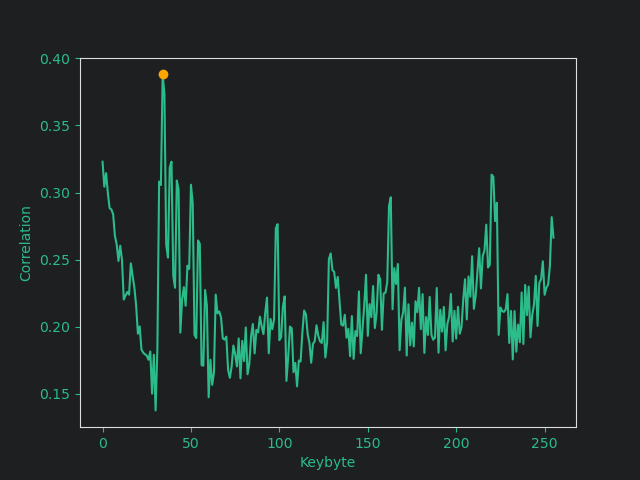

In [96]:
# Setting the Plot Color:
plt.figure(facecolor='#1d1f21')
ax = plt.axes()
ax.set_facecolor("#1d1f21")
ax.tick_params(axis='x', colors='#2bbc8a')
ax.tick_params(axis='y', colors='#2bbc8a')
ax.yaxis.label.set_color('#2bbc8a')
ax.xaxis.label.set_color('#2bbc8a')

ax.spines['bottom'].set_color('#dddddd')
ax.spines['top'].set_color('#dddddd') 
ax.spines['right'].set_color('#dddddd')
ax.spines['left'].set_color('#dddddd')

plt.plot(correlation, '#2bbc8a')
plt.xlabel("Keybyte")
plt.ylabel("Correlation")
plt.plot([keybyte],[correlation[keybyte]], ls="", marker="o", label="points", color="orange")
plt.show()